In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec
#from eofs.xarray import Eof
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils_OC import *
from gpflow.config import default_float
import netCDF4 as nc
import glob
import tensorflow as tf


March 2024 basic GP testing, works with validation on RAMIP T1. Messier/testing notebook version of notebook NorESMem_GP0. 

In [2]:
in_files = glob.glob('../training_data_Ann/inputs*.nc')
out_files = glob.glob('../training_data_Ann/outputs*.nc')



In [3]:
#define perturbation regions as  [lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat]
pert_regions = dict([
    ('gb', [0, -90, 360, 90]),
    ('eu', [165, 37, 210, 73]),
    ('ru', [210, 45, 380, 80]),
    ('ea', [270, -10, 330, 45]),
    ('wa', [240, 0, 270, 45]),
    ('au', [285, -45, 340, -10]),
    ('na', [10, 15, 125, 75]),
    ('sa', [95, -60, 150, 15]),
    ('af', [155, -40, 240, 37])
])

In [4]:
def create_predictor_regions(pert_regions, data_set):
    #for given input dataset and coordingates of regions, sum emissions in those regions and return as dataframe.
    #note: emission units are Tg/yr per gridbox (so summing over lat/lon gives Tg/yr for that region) (not fluxes!)
    inputs = pd.DataFrame()
    X = data_set

    for key_region in pert_regions:
       
        #set up lat/lon slice values:
        lat_slice = slice(pert_regions[key_region][1],pert_regions[key_region][3])
        lon_slice = slice(pert_regions[key_region][0],pert_regions[key_region][2])

        #double check that lon coordinates are correct [-180,180] and if not reassign new coords and sort increasing:
        #if X.lon.max()>180:
        #    print('re-assigning lon to [-180,180]')
        #    X=X.assign_coords(lon=(((X.lon + 180) % 360) - 180)).sortby('lon')

        #Y_CH4 = X['CH4'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('CH4')
        #Y_CH4 = Y_CH4.add_suffix(key_region)
        #inputs = pd.concat([inputs, Y_CH4], axis=1)

        Y_SO2 = X['SO2'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('SO2')
        Y_SO2 = Y_SO2.add_suffix(key_region)
        inputs = pd.concat([inputs, Y_SO2], axis=1)

        Y_BC = X['BC'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('BC')
        Y_BC = Y_BC.add_suffix(key_region)
        inputs = pd.concat([inputs, Y_BC], axis=1)

        Y_OC = X['OC'].sel(lat=lat_slice,lon=lon_slice).sum(('lat','lon')).to_dataframe('OC')
        Y_OC = Y_OC.add_suffix(key_region)
        inputs = pd.concat([inputs, Y_OC], axis=1)

    return inputs

In [5]:
#prepare input data:
# data are annual emissions on 1.9x2.4 degree grid. For training we want a dataframe with total emissions for each region for each year and species, and then concatentate all experiments together.
# data is normalized by mean and std of each species for each experiment later.
# NaNs replaced with 0s.

def add_year(ds):
    #add year as a coordinate to the dataset if it doesn't exist (ie for equilibrium runs where year is not a coordinate)
    if 'year' in ds.coords:
        return ds
    else:
        ds = ds.assign_coords(year=9999)
        ds = ds.expand_dims('year')
        return ds

def prep_inputs(in_files):
    #loop over input files and create a dataframe of emissions for each region for each year and experiment.
    input_df = pd.DataFrame()

    data = xr.open_mfdataset(in_files, combine='nested', concat_dim='year', preprocess=add_year)

    inputs = create_predictor_regions(pert_regions, data)
    inputs0 = inputs.fillna(0)
    input_df = pd.concat([input_df, inputs0], axis=0)

    return input_df


In [6]:
#perpare output:
# data are 1.9x2.4 gridded tas difference from baseline for each experiment.
# training dataframe size is n_years x 96*144
# drop rows that contain NaNs (and drop corresponding rows in input_df)

def prep_outputs(out_files):

    output_df = pd.DataFrame()
    
    for file in out_files:
        print(file)
        data = xr.open_dataset(file)
        data = add_year(data)

        outputs = pd.DataFrame(data['tas_diff'].values.reshape(-1, 96 * 144),index=(data['year']))
        output_df = pd.concat([output_df, outputs], axis=0)

    if output_df.isnull().any(axis=1).sum()>0:
        print('NaNs found in output_df')
        #output_df = output_df.dropna()
        #input_df = input_df.dropna() #fix to drop same rows as output_df
        #print('NaNs dropped')

    return output_df

    #data = xr.open_mfdataset(out_files, combine='nested', concat_dim='year', preprocess=add_year)

    #output_df = pd.DataFrame(data['tas_diff'].values.reshape(-1, 96 * 144),index=data['year'])


    #if output_df.isnull().any(axis=1).sum()>0:
    #    print('NaNs found in output_df')
    #    #output_df = output_df.dropna()
    #    #input_df = input_df.dropna() #fix to drop same rows as output_df
    #    #print('NaNs dropped')

    #return output_df

In [7]:
out_files[21]

'../training_data_Ann\\outputs_ramip_t1.nc'

In [8]:
#create training and test sets:
# keep ssp_245 as test
train_in = in_files[0:21]+in_files[22:24]
test_in = in_files[21]

train_out = out_files[0:21]+out_files[22:24]
test_out = out_files[21]

#prepare training data:
train_input_df = prep_inputs(train_in)
train_output_df = prep_outputs(train_out)

#prepare test data:
test_input_df = prep_inputs([test_in])
test_output = xr.open_dataset(test_out)['tas_diff']

../training_data_Ann\outputs_0xEA_SO2_Ann.nc
../training_data_Ann\outputs_0xEU_SO2_Ann.nc
../training_data_Ann\outputs_0xNA_SO2_Ann.nc
../training_data_Ann\outputs_0xSA_SO2_Ann.nc
../training_data_Ann\outputs_10xEU_BC_Ann.nc
../training_data_Ann\outputs_10xNA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_BC_Ann.nc
../training_data_Ann\outputs_10xSA_SO2_Ann.nc
../training_data_Ann\outputs_5xEA_BC_Ann.nc
../training_data_Ann\outputs_5xEA_SO2_Ann.nc
../training_data_Ann\outputs_5xNA_SO2_Ann.nc
../training_data_Ann\outputs_7xEU_SO2_Ann.nc
../training_data_Ann\outputs_global_anthro_Ann.nc
../training_data_Ann\outputs_global_BC_Ann.nc
../training_data_Ann\outputs_global_OC_Ann.nc
../training_data_Ann\outputs_global_SO2_Ann.nc
../training_data_Ann\outputs_hist-aer.nc
../training_data_Ann\outputs_ramip_af.nc
../training_data_Ann\outputs_ramip_ea.nc
../training_data_Ann\outputs_ramip_nae.nc
../training_data_Ann\outputs_ramip_sa.nc
../training_data_Ann\outputs_ssp245-aer.nc
../training_data_Ann\o

C:\Users\made2928\AppData\Local\Temp\ipykernel_28400\1685828999.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131, projection=proj)


AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

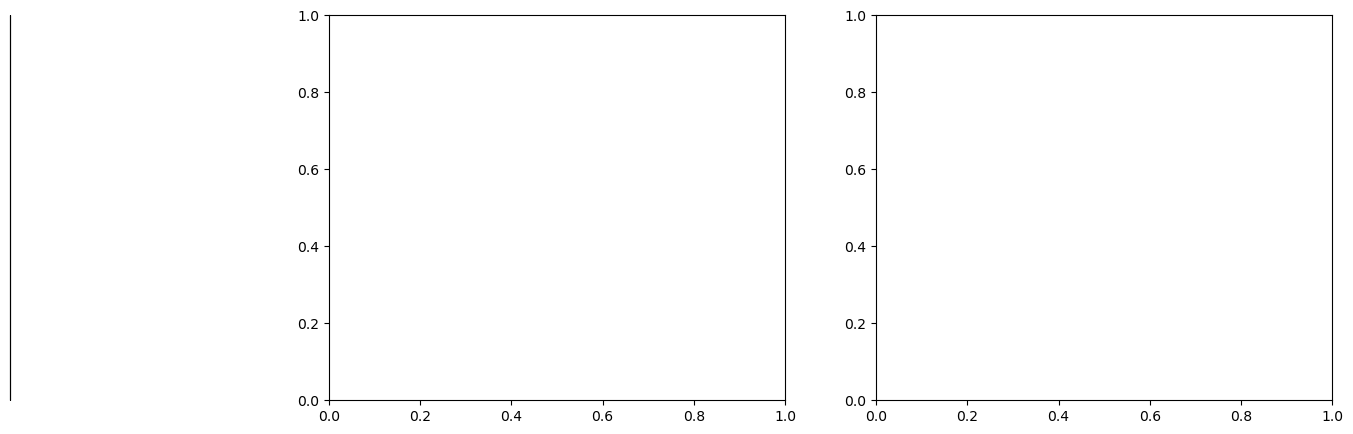

In [9]:
#output_mean = xr.DataArray(train_output_df[:1].values.reshape(96,144), coords={'lat':test_output.lat, 'lon':test_output.lon})
output_mean = xr.open_dataset(out_files[0])['tas_diff']

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
proj = ccrs.Mollweide()
plt.subplot(131, projection=proj)
output_mean.plot(transform=ccrs.PlateCarree(),cmap="coolwarm")                   
plt.gca().coastlines()
plt.title('training output file 1')

test_out = prep_outputs([out_files[0]])
test_reshape = xr.DataArray(test_out[:1].values.reshape(96,144), coords={'lat':test_output.lat, 'lon':test_output.lon})

plt.subplot(132, projection=proj)
test_reshape.plot(transform=ccrs.PlateCarree(),cmap="coolwarm")                   
plt.gca().coastlines()
plt.title('training output processes')


plt.subplot(133, projection=proj)
xr.DataArray(train_output_df[:1].values.reshape(96,144), coords={'lat':test_output.lat, 'lon':test_output.lon}).plot(transform=ccrs.PlateCarree(),cmap="coolwarm")                   
plt.gca().coastlines()
plt.title('training output 1')

In [12]:
#normalize data:
train_output_mean = train_output_df.mean()
train_output_st = train_output_df.std()
train_output_norm = ((train_output_df-train_output_mean)/train_output_st)

train_input_mean = train_input_df.mean()
train_input_st = train_input_df.std()
train_input_norm = ((train_input_df-train_input_mean)/train_input_st)


In [13]:
print(np.shape(train_input_norm))
print(np.shape(train_output_norm))
print(np.shape(test_input_df))

(1932, 27)
(1932, 13824)
(50, 27)


In [14]:
test_input_df.columns

Index(['SO2gb', 'BCgb', 'OCgb', 'SO2eu', 'BCeu', 'OCeu', 'SO2ru', 'BCru',
       'OCru', 'SO2ea', 'BCea', 'OCea', 'SO2wa', 'BCwa', 'OCwa', 'SO2au',
       'BCau', 'OCau', 'SO2na', 'BCna', 'OCna', 'SO2sa', 'BCsa', 'OCsa',
       'SO2af', 'BCaf', 'OCaf'],
      dtype='object')

In [15]:
#set up basic GP model:

# Make kernel
kernel_global = gpflow.kernels.Linear(active_dims=[0, 1, 2])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[3, 6, 9, 12, 15, 18, 21, 24])
kernel_BC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[4, 7, 10, 13, 16, 19, 22, 25])
kernel_OC = gpflow.kernels.Matern32(lengthscales=8 * [1.], active_dims=[5, 8, 11, 14, 17, 20, 23, 26])

kernel = kernel_global + kernel_BC + kernel_SO2 + kernel_OC #+ gpflow.kernels.White()

np.random.seed(5)

#define model
model = gpflow.models.GPR(data=(train_input_norm.astype(np.float64), 
                                train_output_norm.astype(np.float64)),
                        kernel=kernel)

#checkpoint model:
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, log_dir, max_to_keep=5)
manager.save()

checkpoint_task = gpflow.monitor.ExecuteCallback(manager.save)
tast_group = gpflow.monitor.TaskGroup(checkpoint_task, period=5)
monitor = gpflow.monitor.Monitor(tast_group)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 35879478.59636104
        x: [-3.246e+00  4.545e-01 ... -1.913e+00  2.501e-01]
      nit: 143
      jac: [-1.403e+01  1.554e-14 ...  1.289e+01 -2.866e+01]
     nfev: 170
     njev: 170
 hess_inv: <29x29 LbfgsInvHessProduct with dtype=float64>

In [ ]:
#if opt=True, train model, otherwise load from latest checkpoint.

if opt:
    # Define optimizer
    opt = gpflow.optimizers.Scipy()

    # Train model
    opt.minimize(model.training_loss,
                variables=model.trainable_variables,
                options=dict(disp=True, maxiter=1000),
                step_callback=monitor)
    
else:
    #load from checkpoint:
    checkpoint.restore(manager.latest_checkpoint)


In [16]:
model

<gpflow.models.gpr.GPR object at 0x0000019231CC4790>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                                    │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0382083068982749                       │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 4.723734945163718e-17                    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.kernels[1].lengthscales │ Parameter │ Softplus         │         │ True        │ (8,)    │ float64 │ [0.94600346, 2.59184521, 0.81958898...   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.kernels[2].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.0964449408597231                       │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.kernels[2].lengthscales │ Parameter │ Softplus         │         │ True        │ (8,)    │ float64 │ [0.53927075, 3.42934216, 35.85123542...  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.kernels[3].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.1377285778043821                       │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.kernel.kernels[3].lengthscales │ Parameter │ Softplus         │         │ True        │ (8,)    │ float64 │ [0.98901134, 14.14200248, 11.81718134... │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.8260232688726853                       │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════════════════════════════════╛

In [53]:
#save model:

model.compiled_predict_f = tf.function(
    lambda Xnew: model.predict_f(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)],
)
model.compiled_predict_y = tf.function(
    lambda Xnew: model.predict_y(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float64)],
)

save_dir = "saved_model_0"
tf.saved_model.save(model, save_dir)

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.
INFO:tensorflow:Assets written to: saved_model_0\assets


In [56]:
#save parameters:
params_0 = gpflow.utilities.parameter_dict(model)
import pickle
f = open('params_0.pkl', 'wb')
pickle.dump(params_0, f)
f.close()

In [17]:
#test modeL:
import tensorflow as tf
#test_output = test_output.drop('member')
test_input_norm = ((test_input_df-train_input_mean)/train_input_st)

standard_posterior_mean, standard_posterior_var = model.predict_y(test_input_norm.values)
posterior_mean = (standard_posterior_mean * train_output_st) + train_output_mean
train_std = tf.expand_dims(train_output_st,axis=0)
posterior_std = np.sqrt(standard_posterior_var) * train_std

posterior_tas = np.reshape(posterior_mean, np.shape(test_output))#[years, 96, 144])
posterior_tas_std = np.reshape(posterior_std, np.shape(test_output))#[years, 96, 144])
posterior_tas_data = xr.DataArray(posterior_tas, dims=test_output.dims, coords=test_output.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=test_output.dims, coords=test_output.coords)
    


In [144]:
output_std = test_output.sel(year=slice(2050,2059)).std('year')
post_std = np.sqrt(np.power(posterior_tas_std_data.sel(year=slice(2050,2059)),2).mean('year'))

output_mean = test_output.sel(year=slice(2050,2059)).mean('year')
post_mean = posterior_tas_data.sel(year=slice(2050, 2059)).mean('year')

from scipy.stats import ttest_ind_from_stats as ttest
z_em,p_em = ttest(output_mean, output_std, 10, post_mean, post_std, 10, equal_var=False, alternative='two-sided')

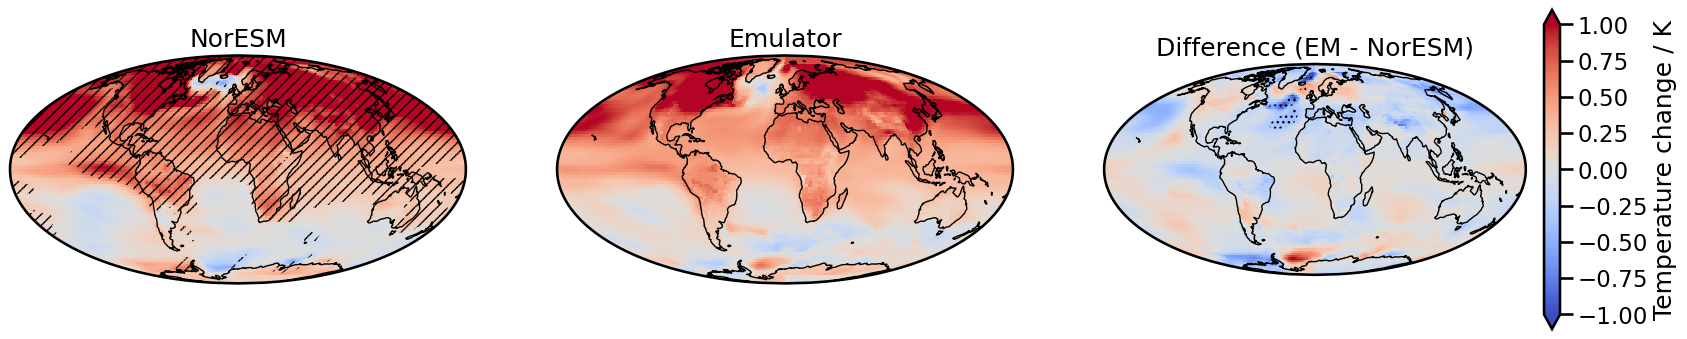

In [185]:
# plotting predictions (mean over all years)
divnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
diffnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
proj = ccrs.Mollweide()

t1_pgrid = np.load('C:/Users/made2928/OneDrive/Documents/MISU/NorESMem/ramip_t1_NorESMpgrid',allow_pickle=True)
p1mask = np.ma.masked_greater(t1_pgrid, 0.05)

with sns.plotting_context("talk"):
    ## Truth
    fig = plt.figure(figsize=(20, 6))
 
    plt.subplot(131, projection=proj)
    #test_output.mean('year').plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
    output_mean.plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
    plt.pcolor(test_output.lon, test_output.lat, p1mask[4,:,:], hatch='///', alpha=0., transform=ccrs.PlateCarree())

    #p_mean = p_amap.mean(axis=0)
    #zm = np.ma.masked_where(p_mean<0.05, p_mean)
    #plt.pcolor(Truth.lon, Truth.lat, zm, hatch='..', alpha=0., transform=ccrs.PlateCarree())                         
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='NorESM')


    # Emulator
    plt.subplot(132, projection=proj)
    #posterior_tas_data.mean('year').plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=divnorm, add_colorbar=False)
    post_mean.plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=divnorm, add_colorbar=False)
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Emulator')

    # Difference
    difference = post_mean - output_mean
    plt.subplot(133, projection=proj)
    difference.plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=diffnorm,
                    cbar_kwargs={"label":"Temperature change / K",'pad':0.04,'fraction':0.035})
    cs = plt.contourf(difference.lon, difference.lat, p_em, colors='none', levels=[0,0.05],
                    hatches=['...'], alpha=0., transform=ccrs.PlateCarree())
    #artists, labels = cs.legend_elements()
    #plt.legend(artists, labels, loc='lower right')

    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference (EM - NorESM)')


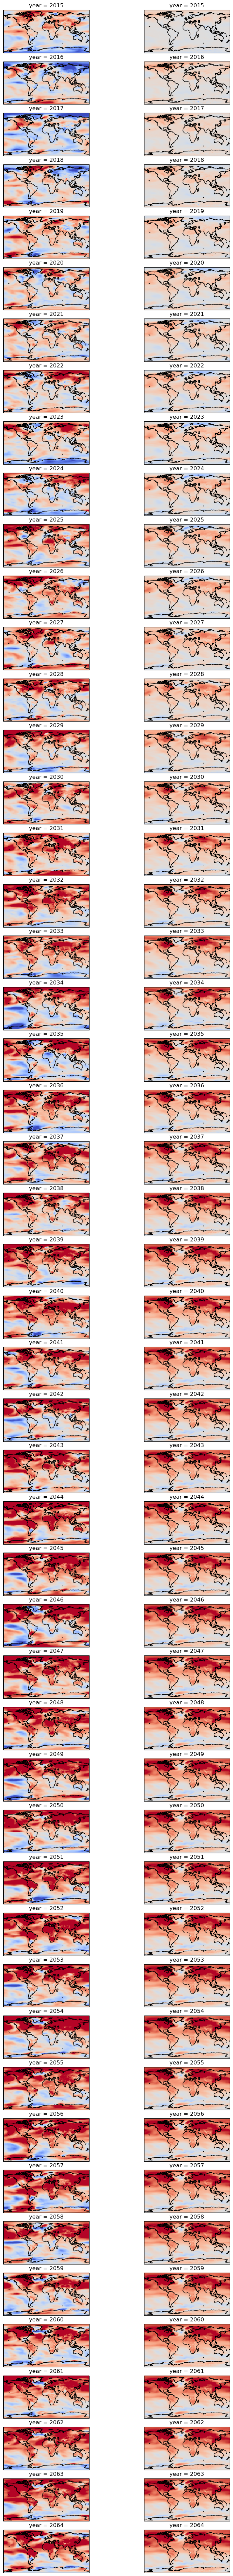

In [123]:
#plot NorESM and Emulator to try and see where the Arctic artifact is coming from
divnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
fig, ax = plt.subplots(50, 2, figsize=(10, 100), subplot_kw={'projection': ccrs.PlateCarree()})

for ii in range(50):
    test_output.isel(year=ii).plot(ax=ax[ii,0],transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
    ax[ii,0].coastlines()

    posterior_tas_data.isel(year=ii).plot(ax=ax[ii,1],transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
    ax[ii,1].coastlines()

In [24]:
test_mean = test_output.sel(year=slice(2050,2059)).mean('year')
em_mean = posterior_tas_data.sel(year=slice(2050,2059)).mean('year')

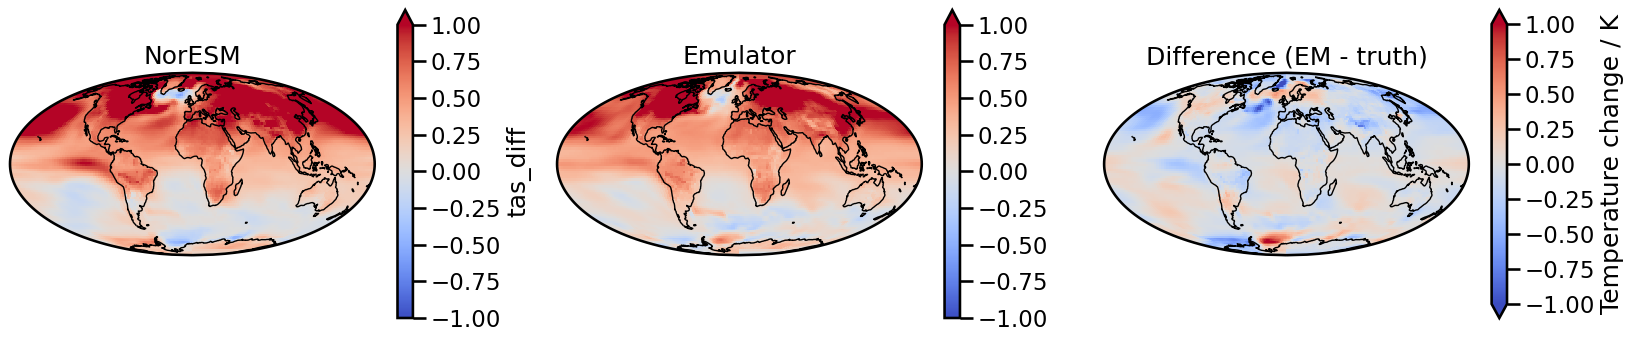

In [25]:
divnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
diffnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=1.)
proj = ccrs.Mollweide()

with sns.plotting_context("talk"):
    ## Truth
    fig = plt.figure(figsize=(20, 4))
 
    plt.subplot(131, projection=proj)
    test_mean.plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm)                     
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='NorESM')

    plt.subplot(132, projection=proj)
    em_mean.plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm)                     
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Emulator')

    plt.subplot(133, projection=proj)
    cm=(em_mean - test_mean).plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=diffnorm, cbar_kwargs={"label":"Temperature change / K"})
    plt.gca().coastlines()
    plt.setp(plt.gca(), title='Difference (EM - truth)')


Text(0, 0.5, 'Global mean temperature change / K')

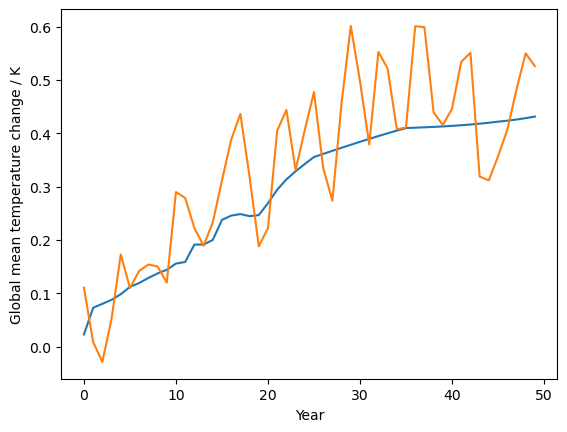

In [20]:
def lat_weighted_mean(x):
    weights = np.cos(np.deg2rad(x.lat))
    return x.weighted(weights).mean(['lat', 'lon'])


plt.plot(lat_weighted_mean(posterior_tas_data))
plt.plot(lat_weighted_mean(test_output))
plt.xlabel('Year')
plt.ylabel('Global mean temperature change / K')

#plt.plot(np.convolve(lat_weighted_mean(test_output)), np.ones(20)/20, mode='valid')


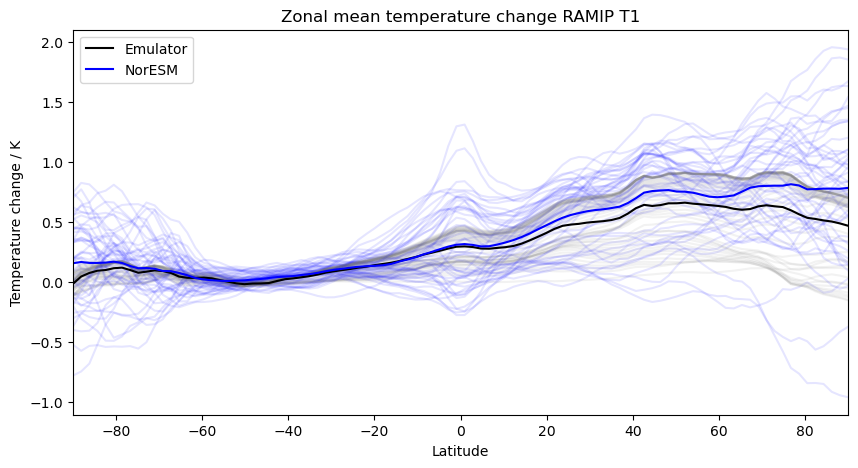

In [38]:
#zonal temperature change:
zonal_post = posterior_tas_data.mean('lon')
zonal_post_std = posterior_tas_std_data.mean('lon').mean('year')
zonal_truth = test_output.mean('lon')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for ii in range(50):
    plt.plot(zonal_post.lat, zonal_post[ii,:],color='grey', alpha=0.1)
    plt.plot(zonal_truth.lat, zonal_truth[ii,:], color='blue', alpha=0.1)
plt.plot(zonal_post.lat, zonal_post.mean('year'), color='black', label='Emulator')
plt.plot(zonal_truth.lat, zonal_truth.mean('year'), color='blue', label='NorESM')
plt.xlabel('Latitude')
plt.ylabel('Temperature change / K')
plt.legend()
plt.title('Zonal mean temperature change RAMIP T1')
plt.autoscale(enable=True, axis='x', tight=True)


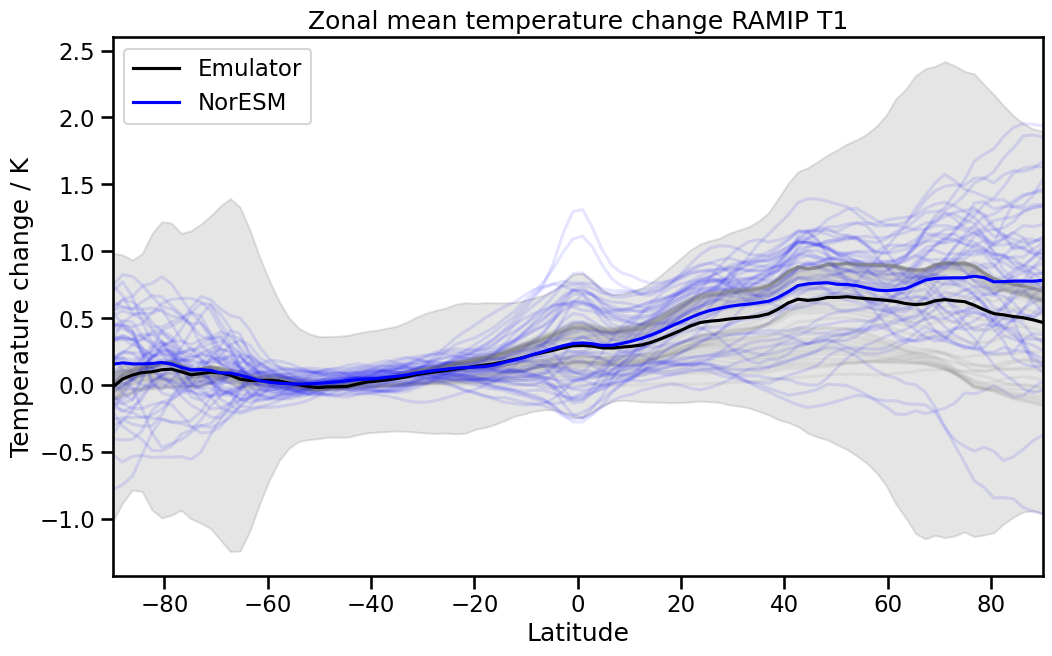

In [40]:
#zonal temperature change with emulator variance:

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    for ii in range(50):
        plt.plot(zonal_post.lat, zonal_post[ii,:],color='grey', alpha=0.1)
        plt.plot(zonal_truth.lat, zonal_truth[ii,:], color='blue', alpha=0.1)
    plt.plot(zonal_post.lat, zonal_post.mean('year'), color='black', label='Emulator')
    plt.fill_between(zonal_post.lat, zonal_post.mean('year')-zonal_post_std, zonal_post.mean('year')+zonal_post_std, color='black', alpha=0.1)
    plt.plot(zonal_truth.lat, zonal_truth.mean('year'), color='blue', label='NorESM')
    plt.xlabel('Latitude')
    plt.ylabel('Temperature change / K')
    plt.legend()
    plt.title('Zonal mean temperature change RAMIP T1')
    plt.autoscale(enable=True, axis='x', tight=True)

In [112]:
xr.open_dataset(test_out)

<xarray.Dataset>
Dimensions:   (lon: 144, lat: 96, year: 50)
Coordinates:
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * year      (year) int64 2015 2016 2017 2018 2019 ... 2060 2061 2062 2063 2064
Data variables:
    tas_diff  (year, lat, lon) float32 ...
    diff_var  (year, lat, lon) float32 ...
Attributes:
    units:          K
    experiment_id:  RAMIP T1: ssp126-ssp370

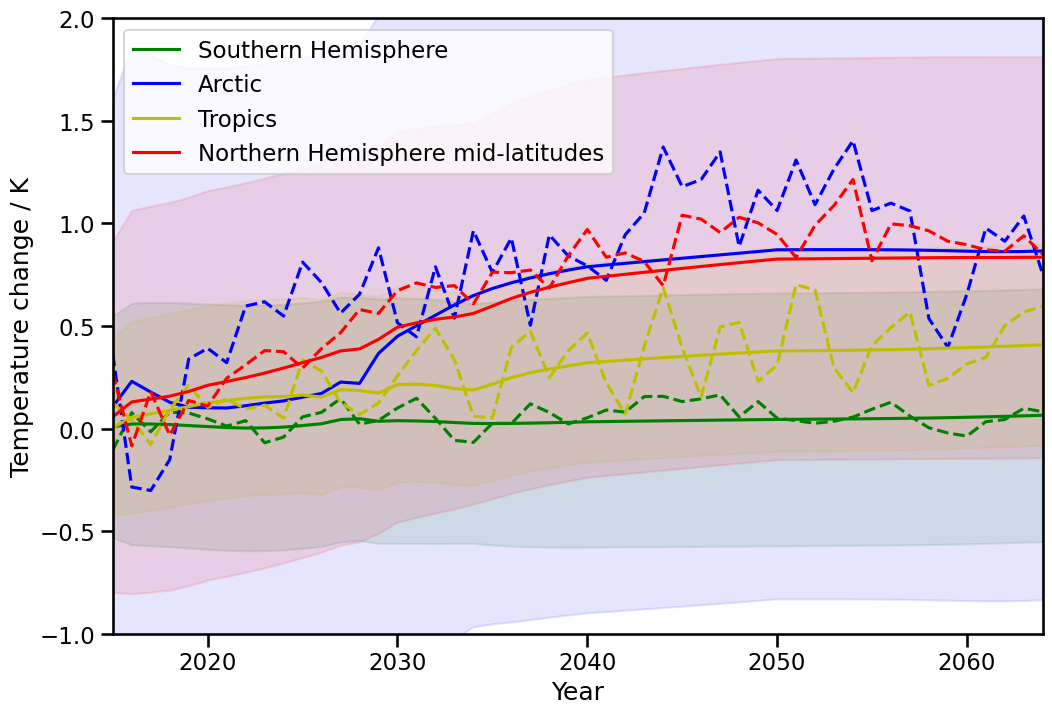

In [114]:
#trends in zonal means:
SH_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(-90,-30)))
SH_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(-90,-30)))
SH_truth = lat_weighted_mean(test_output.sel(lat=slice(-90,-30)))
Arctic_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(60,90)))
Arctic_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(60,90)))
Arctic_truth = lat_weighted_mean(test_output.sel(lat=slice(60,90)))
tropics_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(-30,30)))
tropics_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(-30,30)))
tropics_truth = lat_weighted_mean(test_output.sel(lat=slice(-30,30)))
NHml_post = lat_weighted_mean(posterior_tas_data.sel(lat=slice(30,60)))
NHml_post_std = lat_weighted_mean(posterior_tas_std_data.sel(lat=slice(30,60)))
NHml_truth = lat_weighted_mean(test_output.sel(lat=slice(30,60)))

test_var = xr.open_dataset(test_out)['diff_var']
SH_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(-90,-30))))
Arctic_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(60,90))))
tropics_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(-30,30))))
NHml_truth_std = lat_weighted_mean(np.sqrt(test_var.sel(lat=slice(30,60))))


with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    SH_post.plot(label='Southern Hemisphere',color='g')
    plt.fill_between(SH_post.year, SH_post-SH_post_std, SH_post+SH_post_std, color='g', alpha=0.1)
    SH_truth.plot(color='g',linestyle='--')
    Arctic_post.plot(label='Arctic',color='b')
    plt.fill_between(Arctic_post.year, Arctic_post-Arctic_post_std, Arctic_post+Arctic_post_std, color='b', alpha=0.1)
    Arctic_truth.plot(color='b',linestyle='--')
    tropics_post.plot(label='Tropics',color='y')
    plt.fill_between(tropics_post.year, tropics_post-tropics_post_std, tropics_post+tropics_post_std, color='y', alpha=0.1)
    tropics_truth.plot(color='y',linestyle='--')
    NHml_post.plot(label='Northern Hemisphere mid-latitudes',color='r')
    plt.fill_between(NHml_post.year, NHml_post-NHml_post_std, NHml_post+NHml_post_std, color='r', alpha=0.1)
    NHml_truth.plot(color='r',linestyle='--')

    plt.xlabel('Year')
    plt.ylabel('Temperature change / K')
    plt.legend(loc='upper left')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(-1., 2.)

Text(0.5, 1.0, 'OC')

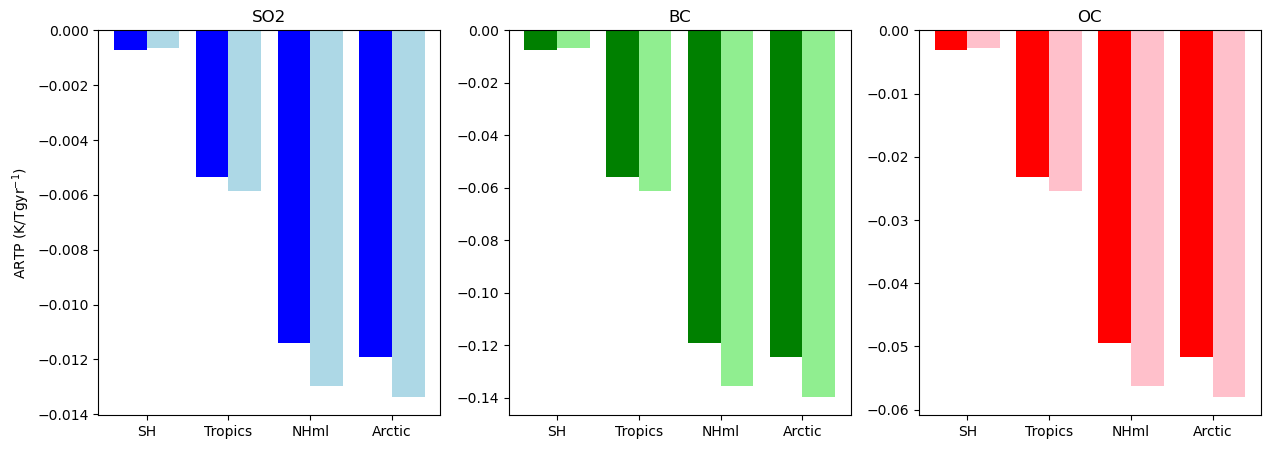

In [109]:
#bar plot ARTPS using above 4 zonal regions:
#ARTP is temperature change per Tg/yr of emissions

test_inputs = xr.open_dataset(test_in)

#calculate ARTPs:
EM_arctic_SO2 = Arctic_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_arctic_BC = Arctic_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_arctic_OC = Arctic_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

EM_SH_SO2 = SH_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_SH_BC = SH_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_SH_OC = SH_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

EM_tropics_SO2 = tropics_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_tropics_BC = tropics_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_tropics_OC = tropics_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

EM_NHml_SO2 = NHml_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_NHml_BC = NHml_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
EM_NHml_OC = NHml_post.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

truth_arctic_so2 = Arctic_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_arctic_bc = Arctic_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_arctic_oc = Arctic_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

truth_SH_so2 = SH_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_SH_bc = SH_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_SH_oc = SH_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

truth_tropics_so2 = tropics_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_tropics_bc = tropics_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_tropics_oc = tropics_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

truth_NHml_so2 = NHml_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['SO2'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_NHml_bc = NHml_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['BC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')
truth_NHml_oc = NHml_truth.sel(year=slice(2050,2064)).mean('year') / test_inputs['OC'].sel(year=slice(2050,2064)).sum(['lat','lon']).mean('year')

#plot ARTPs:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar([0.8,1.8,2.8,3.8], [EM_SH_SO2,EM_tropics_SO2,EM_NHml_SO2,EM_arctic_SO2], width=0.4, color='blue')
ax[0].bar([1.2,2.2,3.2,4.2], [truth_SH_so2,truth_tropics_so2,truth_NHml_so2,truth_arctic_so2], width=0.4, color='lightblue')
ax[0].set_xticks([1,2,3,4])
ax[0].set_xticklabels(['SH','Tropics','NHml','Arctic'])
ax[0].set_ylabel('ARTP (K/Tgyr$^{-1}$)')
ax[0].set_title('SO2')

ax[1].bar([0.8,1.8,2.8,3.8], [EM_SH_BC,EM_tropics_BC,EM_NHml_BC,EM_arctic_BC], width=0.4, color='g')
ax[1].bar([1.2,2.2,3.2,4.2], [truth_SH_bc,truth_tropics_bc,truth_NHml_bc,truth_arctic_bc], width=0.4, color='lightgreen')
ax[1].set_xticks([1,2,3,4])
ax[1].set_xticklabels(['SH','Tropics','NHml','Arctic'])
ax[1].set_title('BC')

ax[2].bar([0.8,1.8,2.8,3.8], [EM_SH_OC,EM_tropics_OC,EM_NHml_OC,EM_arctic_OC], width=0.4, color='r')
ax[2].bar([1.2,2.2,3.2,4.2], [truth_SH_oc,truth_tropics_oc,truth_NHml_oc,truth_arctic_oc], width=0.4, color='pink')
ax[2].set_xticks([1,2,3,4])
ax[2].set_xticklabels(['SH','Tropics','NHml','Arctic'])
ax[2].set_title('OC')

In [155]:

def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data


# Compute RMSEs
print(f"RMSE at 2050-2059: {get_rmse(test_output.sel(year=slice(2050,2059)).mean('year'), posterior_tas_data.sel(year=slice(2050,2059)).mean('year'))}")


RMSE at 2050-2059: 0.17532581939506825


In [ ]:
#plot regional ARTP comparisons between emulator and NorESM:


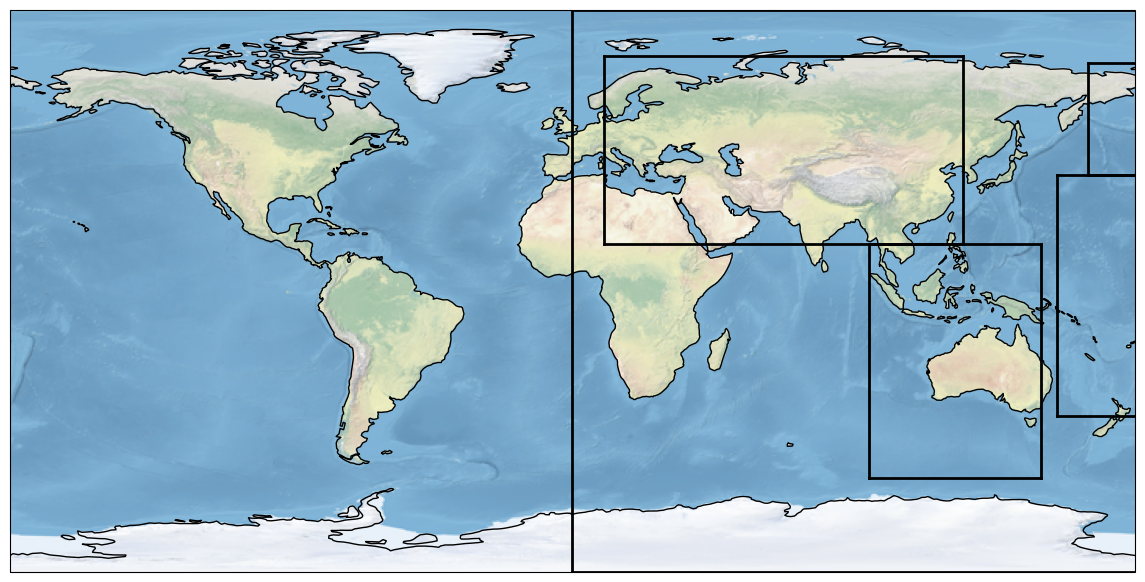

In [6]:
#test map of regions
fig = plt.figure(figsize=(25,14))
gs = gridspec.GridSpec(ncols=5, nrows=5, hspace = 0.6, wspace=0.3)

# Central map
ax_map = fig.add_subplot(gs[1:4,1:4], projection=ccrs.PlateCarree()) #JUST SWITCH PROHECTION TO ONE WITH 360 LONGITUDE!!
ax_map.coastlines()
ax_map.stock_img()

#regions are defined as: [lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat]

def line_regions(ll_coord, ur_coord):
    c = 'k'
    lw = 2
    coordll = ll_coord
    coordur = ur_coord
    coordlr = [ur_coord[0], ll_coord[1]]
    coordul = [ll_coord[0], ur_coord[1]]
    line = matplotlib.lines.Line2D((coordll[0],coordul[0]),(coordll[1],coordul[1])
                                   , linewidth=lw, linestyle='-', c=c)
    ax_map.add_line(line)
    line = matplotlib.lines.Line2D((coordll[0],coordlr[0]),(coordll[1],coordlr[1]),
                                   linewidth=lw, linestyle='-', c=c)
    ax_map.add_line(line)
    line = matplotlib.lines.Line2D((coordur[0],coordul[0]),(coordur[1],coordul[1]),
                                   linewidth=lw, linestyle='-', c=c)
    ax_map.add_line(line)
    line = matplotlib.lines.Line2D((coordur[0],coordlr[0]),(coordur[1],coordlr[1]),
                                   linewidth=lw, linestyle='-', c=c)
    ax_map.add_line(line)
    
for key_region in pert_regions:
    line_regions(pert_regions[key_region][0:2], pert_regions[key_region][2:4])

In [149]:
from scipy import special, integrate, stats


# The normalization constant for the univariate standard Gaussian pdf
_normconst = 1.0 / np.sqrt(2.0 * np.pi)


def _normpdf(x):
    """Probability density function of a univariate standard Gaussian
    distribution with zero mean and unit variance.
    """
    return _normconst * np.exp(-(x * x) / 2.0)

# Cumulative distribution function of a univariate standard Gaussian
# distribution with zero mean and unit variance.
_normcdf = special.ndtr

def crps_gaussian(x, mu, sig, grad=False):
    """
    Computes the CRPS of observations x relative to normally distributed
    forecasts with mean, mu, and standard deviation, sig.

    CRPS(N(mu, sig^2); x)

    Formula taken from Equation (5):

    Calibrated Probablistic Forecasting Using Ensemble Model Output
    Statistics and Minimum CRPS Estimation. Gneiting, Raftery,
    Westveld, Goldman. Monthly Weather Review 2004

    http://journals.ametsoc.org/doi/pdf/10.1175/MWR2904.1

    Parameters
    ----------
    x : scalar or np.ndarray
        The observation or set of observations.
    mu : scalar or np.ndarray
        The mean of the forecast normal distribution
    sig : scalar or np.ndarray
        The standard deviation of the forecast distribution
    grad : boolean
        If True the gradient of the CRPS w.r.t. mu and sig
        is returned along with the CRPS.

    Returns
    -------
    crps : scalar or np.ndarray or tuple of
        The CRPS of each observation x relative to mu and sig.
        The shape of the output array is determined by numpy
        broadcasting rules.
    crps_grad : np.ndarray (optional)
        If grad=True the gradient of the crps is returned as
        a numpy array [grad_wrt_mu, grad_wrt_sig].  The
        same broadcasting rules apply.
    """
    x = np.asarray(x)
    mu = np.asarray(mu)
    sig = np.asarray(sig)
    # standadized x
    sx = (x - mu) / sig
    # some precomputations to speed up the gradient
    pdf = _normpdf(sx)
    cdf = _normcdf(sx)
    pi_inv = 1. / np.sqrt(np.pi)
    # the actual crps
    crps = sig * (sx * (2 * cdf - 1) + 2 * pdf - pi_inv)
    if grad:
        dmu = 1 - 2 * cdf
        dsig = 2 * pdf - pi_inv
        return crps, np.array([dmu, dsig])
    else:
        return crps

In [150]:
crps = crps_gaussian(test_output, posterior_tas_data, posterior_tas_std_data)
crps = xr.DataArray(crps, dims=test_output.dims, coords=test_output.coords)

In [151]:
def lat_mean(data):
    weights = np.cos(np.deg2rad(data.lat))
    return data.weighted(weights).mean(['lat', 'lon'])

In [152]:
lat_mean(crps).sel(year=slice(2050,2059)).mean('year')

<xarray.DataArray ()>
array(0.2429694)

In [26]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions
    
    '''
    try:
        from cis.data_io.common_data import CommonData
        # Unpack common data objects
        if isinstance(diff_mean, CommonData):
            diff_mean = diff_mean.data
        if isinstance(diff_std, CommonData):
            diff_std = diff_std.data
        if isinstance(diff_num, CommonData):
            diff_num = diff_num.data
    except:
        pass
    '''
    
    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p


In [ ]:
z_nor,p_nor = ttest(output_mean, output_std, 30, post_mean, post_std, 30, equal_var=False, alternative='two-sided')

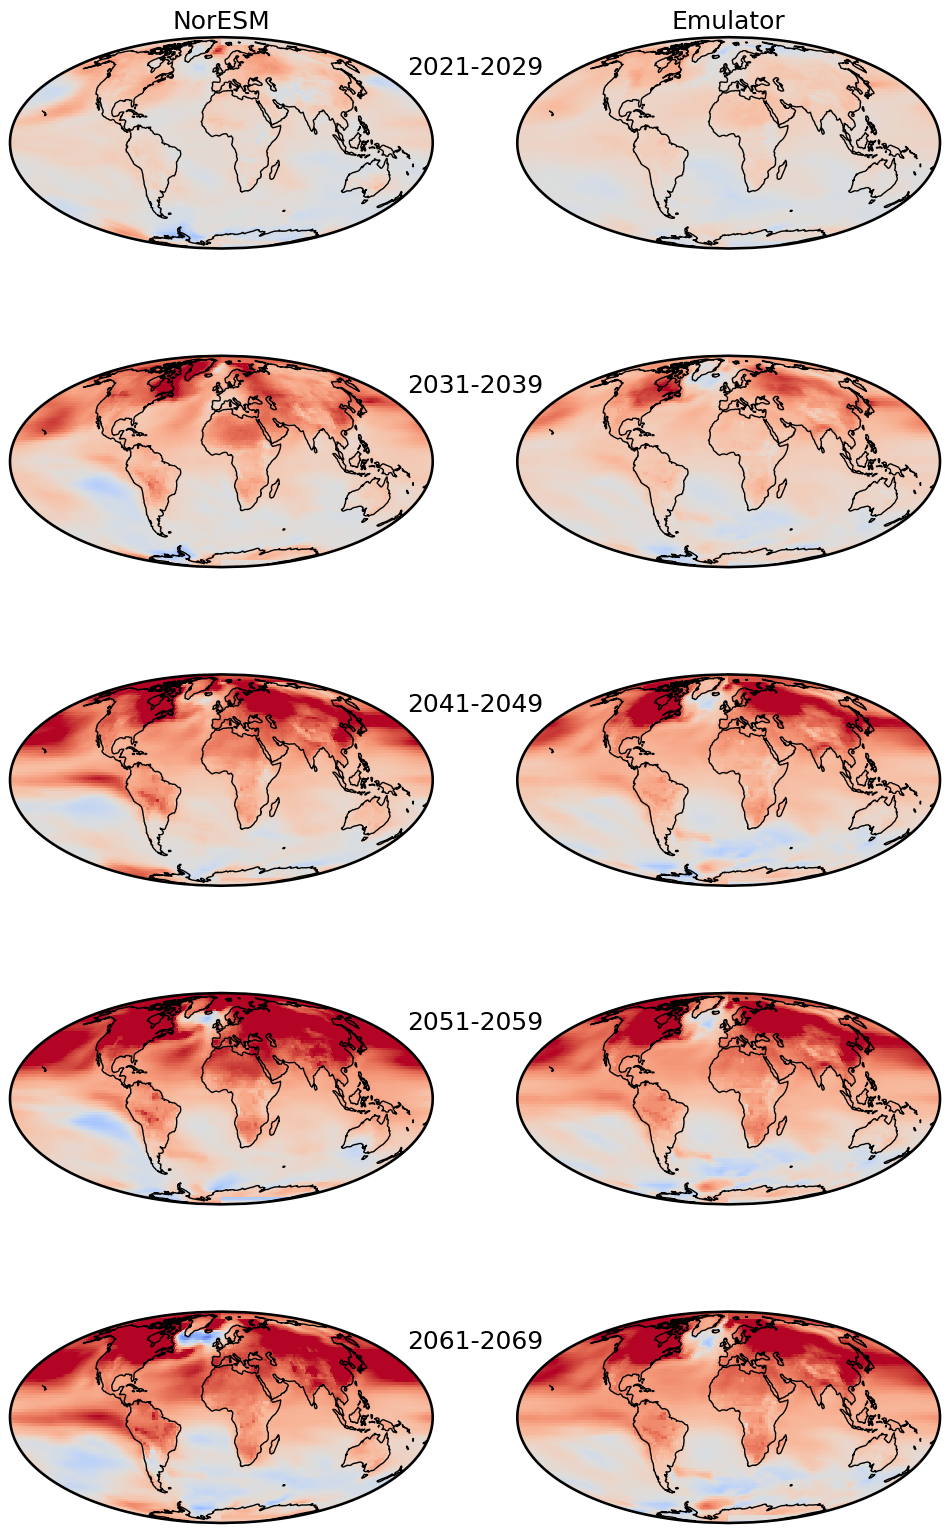

In [73]:
#plot 10-year means for hist-aer test, to show when/how RMSE degrades.

plt.figure(figsize=(12,18))
with sns.plotting_context("talk"):
    for i in range(5):
        for j in range(2):
            ax = plt.subplot2grid((5,2), (i,j), projection=proj)
            if j==0:
                test_output[10*i:10*(i+1)].mean('year').plot(transform=ccrs.PlateCarree(),cmap="coolwarm", norm=divnorm, add_colorbar=False)
                plt.gca().coastlines()
                ax.text(1.1, 0.8, str(2021+10*i) + '-' + str(2029+10*i), va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax.transAxes)
                if i==0:
                    plt.setp(plt.gca(), title='NorESM')
            if j==1:
                posterior_tas_data[10*i:10*(i+1)].mean('year').plot(transform=ccrs.PlateCarree(), cmap="coolwarm", norm=divnorm, add_colorbar=False
                )
                plt.gca().coastlines()
                if i==0:
                    plt.setp(plt.gca(), title='Emulator')

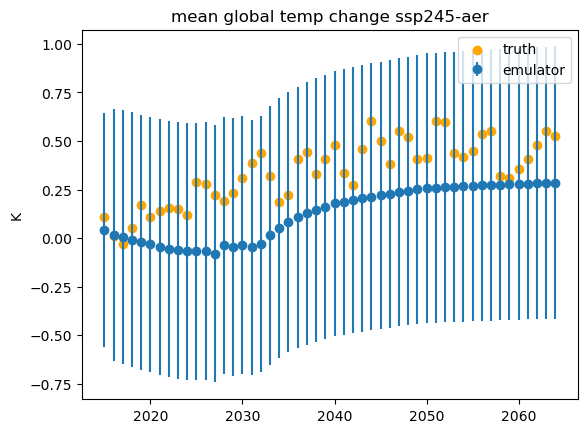

In [20]:
#def lat_weighted_mean(ds):
#    weights = np.cos(np.deg2rad(ds.lat))
#    weights.name = "weights"
#    gl_mean = ds.weighted(weights).mean(("lon", "lat"))
#    return gl_mean

em_glb_temp = lat_weighted_mean(posterior_tas_data)
glb_temp = lat_weighted_mean(test_output)
em_std = lat_weighted_mean(posterior_tas_std_data)
#plt.scatter(em_glb_temp.year, em_glb_temp, label='emulator')
plt.errorbar(em_glb_temp.year, em_glb_temp, yerr=em_std, fmt='o',label='emulator' )
plt.scatter(glb_temp.year,glb_temp, label='truth',color='orange')
plt.title('mean global temp change')
plt.ylabel('K')
plt.legend(loc='best')

In [24]:
df = glb_temp.to_dataframe('NorESM')
df['emulator'] = em_glb_temp
df['year'] = df.index

sns.jointplot(data=df, x='NorESM', y='emulator', kind='reg')
#plt.scatter(glb_temp, em_glb_temp)
#plt.xlabel('emulator')
#plt.ylabel('NorESM')
#plt.xlim(-1.0,0)
#plt.ylim(-0.6,0)

NameError: name 'glb_temp' is not defined

Text(0.5, 1.0, 'global mean temp')

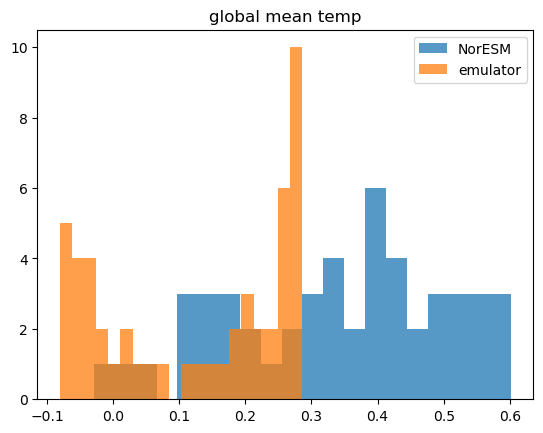

In [22]:
plt.hist(glb_temp, bins=20, alpha=0.75, label='NorESM')
plt.hist(em_glb_temp, bins=20, alpha=0.75, label='emulator')
plt.legend(loc='best')
plt.title('global mean temp')

In [22]:
tas_em = posterior_tas_data.values.ravel()
tas_nor = test_output.values.ravel()


Text(0.5, 1.0, 'gridded temp')

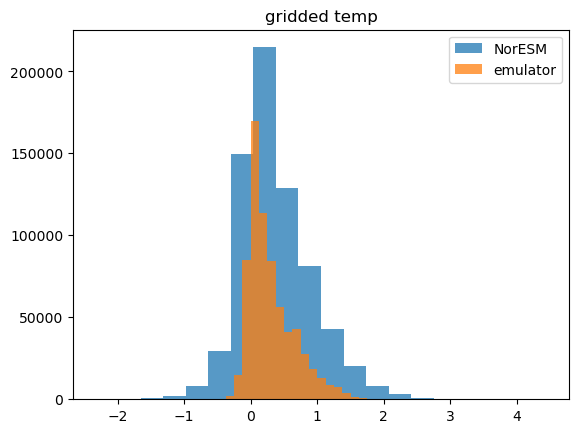

In [23]:

plt.hist(tas_nor, bins=20, alpha=0.75, label='NorESM')
plt.hist(tas_em, bins=20, alpha=0.75, label='emulator')
plt.legend(loc='best')
plt.title('gridded temp')

In [38]:
output_baseline = xr.open_dataset(test_out)['baseline']

In [40]:
output_tas = test_output + output_baseline

In [70]:
test_2020s = test_output.sel(year=slice(2021,2030)).values.reshape(-1, 96 * 144)
em_2020s = posterior_tas_data.sel(year=slice(2021,2030)).values.reshape(-1, 96 * 144)

df_2020 = pd.DataFrame()
df_2020['NorESM'] = test_2020s
df_2020['emulator'] = em_2020s
df_2020['year'] = df_2020.index

sns.jointplot(data=df_2020, x='NorESM', y='emulator', kind='reg')

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [45]:
test_output.year

<xarray.DataArray 'year' (year: 80)>
array([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
       2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056,
       2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068,
       2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092,
       2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100], dtype=int64)
Coordinates:
  * year     (year) int64 2021 2022 2023 2024 2025 ... 2096 2097 2098 2099 2100
    member   object ...

In [48]:

def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(test_output[29], posterior_tas_data[29])}")
print(f"RMSE at 2100: {get_rmse(test_output[79], posterior_tas_data[79])}")
print(f"RMSE 2045-2055: {get_rmse(test_output[24:35], posterior_tas_data[24:35]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(test_output[69:], posterior_tas_data[69:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(test_output[29:], posterior_tas_data[29:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(test_output[-20:].mean(dim='year'), posterior_tas_data[-20:].mean(dim='year'))}")


RMSE at 2050: 0.8194829599939703
RMSE at 2100: 0.8410006468726018
RMSE 2045-2055: 0.7961936298352825
RMSE 2090-2100: 0.8892331582480573
RMSE 2050-2100: 0.8898493669207926
RMSE average last 20y: 0.48767223805384496


In [49]:
from xskillscore import crps_gaussian

print(crps_gaussian(test_output.sel(year=slice(2050, 2100)), posterior_tas_data.sel(year=slice(2050, 2100)), posterior_tas_std_data.sel(year=slice(2050, 2100)), weights=np.cos(np.deg2rad(test_output.lat))))

ModuleNotFoundError: No module named 'xskillscore'